# TP CLUSTERING DANS UN BUT DE SEGMENTATION

In [1]:
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import os
os.chdir("C:\\Users\\dgr\\OneDrive - Publicis Groupe\\Documents\\Formations\\SCU Python\\NEW\\Python-ML\\data")


## LES DONNEES
https://www.kaggle.com/apratim87/housingdata/version/1#housingdata.csv
Housing data

Variables in order: 

#CRIM per capita crime rate by town 
#ZN proportion of residential land zoned for lots over 25,000 sq.ft. 
#INDUS proportion of non-retail business acres per town 
#CHAS Charles River dummy variable (= 1 if tract bounds river; 0 otherwise) 
#NOX nitric oxides concentration (parts per 10 million) 
#RM average number of rooms per dwelling 
#AGE proportion of owner-occupied units built prior to 1940 
#DIS weighted distances to five Boston employment centres 
#RAD index of accessibility to radial highways 
#TAX full-value property-tax rate per $10,000 
#PTRATIO pupil-teacher ratio by town 
#Blackpop variable corrélée à la  proportion of blacks by town 
#LSTAT ratio de lower status of the population 
#MEDV Median value of owner-occupied homes en milliers de dollars


In [2]:
housing = pd.read_csv('housingdata.csv',header=0,index_col=False,sep=',',
names=["CRIM","ZN","INDUS","CHAS","NOX","RM","AGE","DIS","RAD","TAX", "PTRATIO","BlackPop","LSTAT","MEDV"])

In [3]:
housing.CHAS=housing.CHAS.astype(bool)
#Housing data
housing.dtypes
# nb de lignes 3333
housing.shape[0]
# nb de vars 21
housing.shape[1]
housing.info()
housing.columns


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   CRIM      505 non-null    float64
 1   ZN        505 non-null    float64
 2   INDUS     505 non-null    float64
 3   CHAS      505 non-null    bool   
 4   NOX       505 non-null    float64
 5   RM        505 non-null    float64
 6   AGE       505 non-null    float64
 7   DIS       505 non-null    float64
 8   RAD       505 non-null    int64  
 9   TAX       505 non-null    int64  
 10  PTRATIO   505 non-null    float64
 11  BlackPop  505 non-null    float64
 12  LSTAT     505 non-null    float64
 13  MEDV      505 non-null    float64
dtypes: bool(1), float64(11), int64(2)
memory usage: 51.9 KB


Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'BlackPop', 'LSTAT', 'MEDV'],
      dtype='object')

In [4]:

stats = housing.describe(include='all')



In [5]:
# créer 3 groupes de valeur des logements <15 , 15-25 et 25+
housing["Valeur_Immo"] = '2.15k-25k$'
housing.loc[housing['MEDV'] >= 25, 'Valeur_Immo'] = '3.>25k$'
housing.loc[housing['MEDV'] <15, 'Valeur_Immo'] = '1.<15k$'
housing.Valeur_Immo.describe()
housing.info()
housing.Valeur_Immo=housing.Valeur_Immo.astype('category')
housing.info() # réduction de la mém

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   CRIM         505 non-null    float64
 1   ZN           505 non-null    float64
 2   INDUS        505 non-null    float64
 3   CHAS         505 non-null    bool   
 4   NOX          505 non-null    float64
 5   RM           505 non-null    float64
 6   AGE          505 non-null    float64
 7   DIS          505 non-null    float64
 8   RAD          505 non-null    int64  
 9   TAX          505 non-null    int64  
 10  PTRATIO      505 non-null    float64
 11  BlackPop     505 non-null    float64
 12  LSTAT        505 non-null    float64
 13  MEDV         505 non-null    float64
 14  Valeur_Immo  505 non-null    object 
dtypes: bool(1), float64(11), int64(2), object(1)
memory usage: 55.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 15 columns):
 # 

## REDUCTION DE DIMENSIONS AVEC ACP

In [6]:
# ACP sur les var numériques
# l'ACP doit être appliqué sur des données standardisées
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# MEDV est plus une variable qu'on veut projetter
X = housing.drop(["CHAS","MEDV","Valeur_Immo"],axis=1)
# on écrase et on standardise
X = StandardScaler().fit_transform(housing.drop(["CHAS","MEDV","Valeur_Immo"],axis=1))

In [7]:
# CALCUL ACP A LA MAIN
matCorr = np.corrcoef(X,rowvar = False) # matrice des corrélations, rowvar =F signifie que les col sont en col
# diagonalisation fonction eig donne  vecteur de valeurs propres et un array pour  les vecteurs propres, 1 par colonne
eigenVal, eigenVec = np.linalg.eig(matCorr)
# eigenVal permet d'apprécier le nb daxes selon critere de kaiser
##ou
#model_scaling =  StandardScaler().fit(X)
## application du scaling à un nouvel individu
#nouvel_individu=X[0:1,:]
#nouvel_individu_cr=model_scaling.transform(nouvel_individu)

In [8]:
eigenVal

array([6.12511893, 1.34237511, 1.17972949, 0.83633363, 0.66505743,
       0.53753416, 0.39666844, 0.06444181, 0.27731536, 0.16937287,
       0.18628047, 0.21977229])

In [9]:
# CALCUL ACP AVEC SKLEARN

X.mean(axis=0)
X.std(axis=0)

pca_housing = PCA(n_components=X.shape[1]).fit(X)
CP_housing = pca_housing.transform(X)
# projection des 505 villes sur les nouvelles dimensions

[0.51042658 0.11186459 0.09831079 0.06969447 0.05542145 0.04479451
 0.0330557  0.02310961 0.01831436 0.01552337 0.01411441 0.00537015]
[ 51.04  62.23  72.06  79.03  84.57  89.05  92.36  94.67  96.5   98.05
  99.46 100.  ]


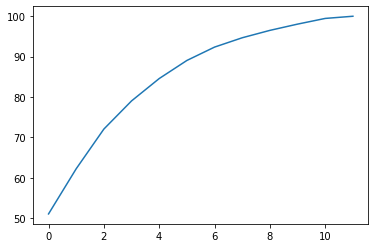

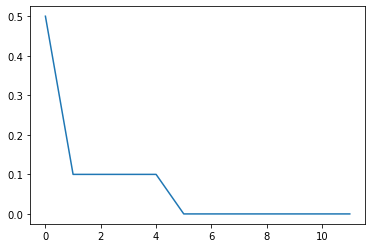

In [10]:
print(pca_housing.explained_variance_ratio_) # 3 composantes expliquent 72% de la variance des données
print(np.cumsum(np.round(pca_housing.explained_variance_ratio_, decimals=4)*100))
plt.plot(np.cumsum(np.round(pca_housing.explained_variance_ratio_, decimals=4)*100))
plt.figure()
plt.plot(np.round(pca_housing.explained_variance_ratio_, decimals=1))

# les coordonnées des individus sur les deux axes
# test=pd.DataFrame(CP_housing[0:12,0:2], columns = ['CP1', 'CP2'])

In [11]:
# examine l'objet
print(pca_housing.__dict__)
from math import sqrt 
print(pca_housing.singular_values_)
# valeur propre λi=si**2/(n−1)
print(list(map(lambda x:(x**2)/(len(X)-1),np.array(pca_housing.singular_values_))) )
# On trouve des résultats proches de eigenval

{'n_components': 12, 'copy': True, 'whiten': False, 'svd_solver': 'auto', 'tol': 0.0, 'iterated_power': 'auto', 'random_state': None, '_fit_svd_solver': 'full', 'mean_': array([-5.62806127e-17,  1.75876915e-17,  2.25122451e-16, -3.09543370e-16,
       -3.16578447e-17,  1.82911991e-16,  1.68841838e-16,  0.00000000e+00,
       -1.12561225e-16, -1.13968241e-15, -5.34665821e-16, -2.81403064e-17]), 'noise_variance_': 0.0, 'n_samples_': 505, 'n_features_': 12, 'components_': array([[ 0.25096807, -0.25632016,  0.34663549,  0.34298532, -0.18923569,
         0.31379316, -0.32164886,  0.31972077,  0.338499  ,  0.20467099,
        -0.20291546,  0.30970598],
       [ 0.40220098,  0.4394281 , -0.1091282 , -0.16340448,  0.08068794,
        -0.31397828,  0.32530173,  0.38537913,  0.32138566,  0.16927991,
        -0.3374333 , -0.03592319],
       [ 0.06548158,  0.08804452,  0.03366535,  0.2369054 ,  0.67851548,
         0.1659233 , -0.25593269,  0.11087695,  0.07573032, -0.48657484,
        -0.1855186

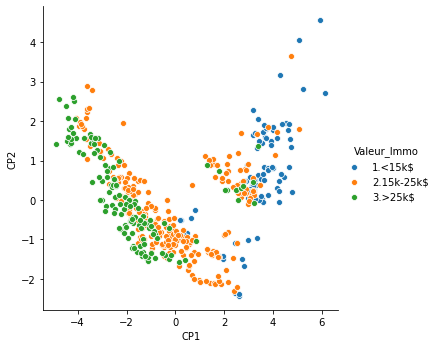

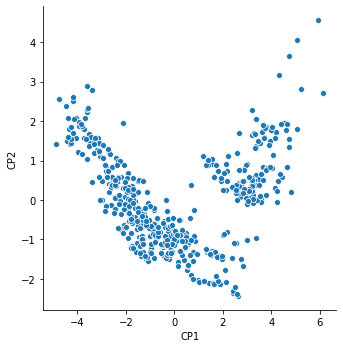

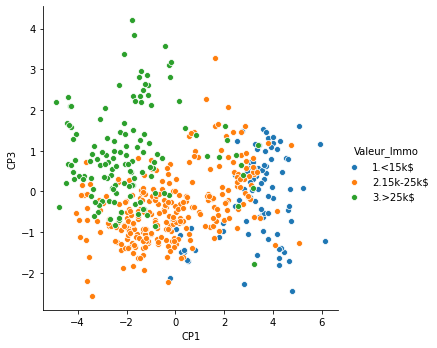

In [12]:
import seaborn as sns
targets = housing.Valeur_Immo.unique()

# 3 axes
finalDf = pd.concat([pd.DataFrame(CP_housing[:,0:3], columns = ['CP1', 'CP2','CP3']), housing[["CHAS","MEDV",'Valeur_Immo']]], axis = 1)
sns.pairplot(x_vars='CP1', y_vars='CP2', data=finalDf, hue="Valeur_Immo", height=5)
sns.pairplot(x_vars='CP1', y_vars='CP2', data=finalDf, height=5)
sns.pairplot(x_vars='CP1', y_vars='CP3', data=finalDf, hue="Valeur_Immo", height=5)
# Les 3 catégories de valeur immobilière sont assez corrélées avec l'axe 1 et 3

## INTERPRETATION DES AXES

#CP1 correle + avec
#CRIM
#INDUS
#NOX
#AGE
#RAD
#LSTAT
#
#et - avec
#ZN
#DIS
#TAX
#
#CP2 +
#CRIM ZN
#RAD
#TAX
#
#- black
#age
#
#CP3
#RM +
#et ptration - 
#
#à noter que MEDV est corree - avec CP1
#et + avec CP3 et orthogonal à CP2

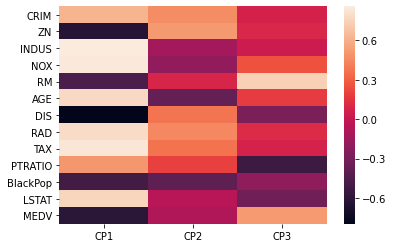

In [13]:

# corrélations etre les axes et les variables
#np.corrcoef(matNum,rowvar = False)
# 7 valeurs propres >1
import matplotlib.pyplot as plt
analyse = pd.concat([pd.DataFrame(CP_housing[:,0:3], columns = ['CP1', 'CP2','CP3']), housing[["CRIM","ZN","INDUS","NOX","RM","AGE","DIS","RAD","TAX", "PTRATIO","BlackPop","LSTAT","MEDV"]]], axis = 1)
corr=analyse.corr().loc[["CRIM","ZN","INDUS","NOX","RM","AGE","DIS","RAD","TAX", "PTRATIO","BlackPop","LSTAT","MEDV"],["CP1","CP2","CP3"]]
plt.figure()
sns.heatmap(corr,xticklabels=corr.columns.values,yticklabels=corr.index.values)

del corr


In [14]:
del finalDf, stats

## CLUSTERING MIXTE

La classification mixte permet de garder les qualités des méthodes de nuées dynamiques 
et de la classification hiérarchique en contournant leurs inconvénients.
On commence par une k-means pour diminuer la dimension du problème 
puis on fait une classification hiérarchique sur les centroides.

In [15]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from scipy import cluster
from sklearn.cluster import AgglomerativeClustering

In [16]:
# On fait une k-means avec beaucoup de clusters et on récupère les coordonnées des centroides

k_means_cent = KMeans(n_clusters = 25, random_state = 2016).fit(CP_housing[:,0:3])
# barycentres des 25 classes issues de la partition KM
centroides = k_means_cent.cluster_centers_

{'icoord': [[15.0, 15.0, 25.0, 25.0],
  [45.0, 45.0, 55.0, 55.0],
  [35.0, 35.0, 50.0, 50.0],
  [65.0, 65.0, 75.0, 75.0],
  [42.5, 42.5, 70.0, 70.0],
  [20.0, 20.0, 56.25, 56.25],
  [5.0, 5.0, 38.125, 38.125],
  [115.0, 115.0, 125.0, 125.0],
  [105.0, 105.0, 120.0, 120.0],
  [95.0, 95.0, 112.5, 112.5],
  [85.0, 85.0, 103.75, 103.75],
  [135.0, 135.0, 145.0, 145.0],
  [155.0, 155.0, 165.0, 165.0],
  [140.0, 140.0, 160.0, 160.0],
  [175.0, 175.0, 185.0, 185.0],
  [195.0, 195.0, 205.0, 205.0],
  [215.0, 215.0, 225.0, 225.0],
  [235.0, 235.0, 245.0, 245.0],
  [220.0, 220.0, 240.0, 240.0],
  [200.0, 200.0, 230.0, 230.0],
  [180.0, 180.0, 215.0, 215.0],
  [150.0, 150.0, 197.5, 197.5],
  [94.375, 94.375, 173.75, 173.75],
  [21.5625, 21.5625, 134.0625, 134.0625]],
 'dcoord': [[0.0, 1.8945334137681231, 1.8945334137681231, 0.0],
  [0.0, 1.198552313912313, 1.198552313912313, 0.0],
  [0.0, 1.804395231458763, 1.804395231458763, 1.198552313912313],
  [0.0, 2.105196445205521, 2.105196445205521, 0.0],

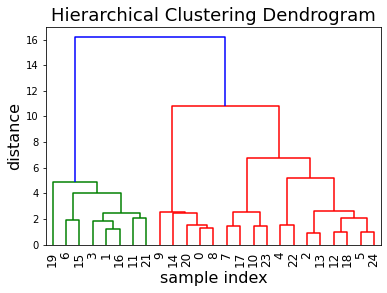

In [17]:


# 25 individus fictifs (barycentres)

# On trace le dendogramme 
# étape préliminaire avec la cluster.hierarchy (CAH): bénéfice de pouvoir représenter
Z = cluster.hierarchy.linkage(centroides, method='ward', metric='euclidean')
plt.figure()

plt.title('Hierarchical Clustering Dendrogram', fontsize=18)

plt.xlabel('sample index', fontsize=16)

plt.ylabel('distance', fontsize=16)
cluster.hierarchy.dendrogram(Z, leaf_font_size=12, leaf_rotation=90.) 


In [18]:
# etape partitionner par rapport au nombre = 3 ou 4
# On peut ensuite réaliser le clustering à l'aide de scikit-learn
hac_cent = AgglomerativeClustering(n_clusters = 4, affinity = 'euclidean', linkage = 'ward')
hac_cent.fit(centroides)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=4,
                        pooling_func='deprecated')

In [19]:
# On récupère le cluster assigné lors du K-means puis lors du CAH pour avoir un cluster final pour chaque observation
kmeans_cent_df = pd.DataFrame(k_means_cent.labels_, columns = ['K-means_cent']).reset_index()
hac_cent_df = pd.DataFrame(hac_cent.labels_, columns = ['Typologie']).reset_index()
cluster_cent = pd.merge(kmeans_cent_df, hac_cent_df, left_on=['K-means_cent'], right_on=['index'], how='left')
cluster_cent = cluster_cent.drop(['K-means_cent','index_y'], axis =1)


In [20]:
cluster_cent.Typologie.value_counts()
cluster_cent.Typologie.value_counts().apply(lambda x:x/len(cluster_cent.Typologie))

typologie = pd.merge(left=housing, right=cluster_cent, how='inner',
		   left_index=True, right_index=True)

In [21]:

barycentres=typologie.groupby(['Typologie'])[["CRIM","ZN","INDUS","CHAS","NOX","RM","AGE","DIS","RAD","TAX", "PTRATIO","BlackPop","LSTAT","MEDV"]].mean()


In [22]:
#Pour chaque cluster, on calcule la moyenne des variables quantitatives
# et la proportion des variables qualitatives. On peut ainsi voir en quels domaines les clusters se différencient. Ci-dessous le portrait robot de la classification mixte :

# Variables quanti : moyenne de la variable
# le index =false permet que le resultat reprenne bien les var en group by
stats=typologie.groupby(['Typologie'])[["CRIM","ZN","INDUS","CHAS","NOX","RM","AGE","DIS","RAD","TAX", "PTRATIO","BlackPop","LSTAT","MEDV"]].mean()

# Variables quali : proportion de la variable dans chaque catégorie
pd.crosstab(typologie['Typologie'], typologie['CHAS'], normalize=True)
pd.crosstab(typologie['Typologie'], typologie['Valeur_Immo'], normalize='index')


Valeur_Immo,1.<15k$,2.15k-25k$,3.>25k$
Typologie,,,
0,0.048035,0.681223,0.270742
1,0.540741,0.377778,0.081481
2,0.000000,0.384615,0.615385
3,0.200000,0.740000,0.060000


In [23]:
# UTILISER UNE FONCTION DE PORTRAITS ROBOTS
import sys
sys.path.append("C:\\Users\\dgr\\OneDrive - Publicis Groupe\\Documents\\Formations\\SCU Python\\NEW\\modules")
sys.path


['C:\\Users\\dgr\\OneDrive - Publicis Groupe\\Documents\\Formations\\SCU Python\\NEW\\Python-ML\\notebooks',
 'C:\\Users\\dgr\\AppData\\Local\\Continuum\\anaconda3\\python37.zip',
 'C:\\Users\\dgr\\AppData\\Local\\Continuum\\anaconda3\\DLLs',
 'C:\\Users\\dgr\\AppData\\Local\\Continuum\\anaconda3\\lib',
 'C:\\Users\\dgr\\AppData\\Local\\Continuum\\anaconda3',
 '',
 'C:\\Users\\dgr\\AppData\\Local\\Continuum\\anaconda3\\lib\\site-packages',
 'C:\\Users\\dgr\\AppData\\Local\\Continuum\\anaconda3\\lib\\site-packages\\win32',
 'C:\\Users\\dgr\\AppData\\Local\\Continuum\\anaconda3\\lib\\site-packages\\win32\\lib',
 'C:\\Users\\dgr\\AppData\\Local\\Continuum\\anaconda3\\lib\\site-packages\\Pythonwin',
 'C:\\Users\\dgr\\AppData\\Local\\Continuum\\anaconda3\\lib\\site-packages\\IPython\\extensions',
 'C:\\Users\\dgr\\.ipython',
 'C:\\Users\\dgr\\OneDrive - Publicis Groupe\\Documents\\Formations\\SCU Python\\NEW\\modules']

In [24]:
from portraits_robots_quanti import portraits_robot_quanti

In [25]:
from pouvoir_discriminant import pouvoir_discriminant

In [26]:
stats=portraits_robot_quanti(typologie, 'Typologie', ["CRIM","ZN","INDUS","CHAS","NOX","RM","AGE","DIS","RAD","TAX", "PTRATIO","BlackPop","LSTAT","MEDV"])

In [27]:
# Pour chaque variable on a la moyenne de la variable par classe de la typologie et la pvalue associée
stats

,index,VARIABLE,p-value_0,p-value_1,p-value_2,p-value_3,y_0,y_1,y_2,y_3,y_All
0,NaN,Effectif,NaN,NaN,NaN,NaN,229.000000,135.000000,91.000000,50.000000,505.000000
1,6.0,AGE,0.0119987,1.77783e-27,2.71509e-56,5.11718e-13,65.129258,89.896296,30.998901,95.244000,68.581584
2,11.0,BlackPop,1.63092e-12,8.85317e-28,0.000157946,0.296985,387.399432,287.118889,389.176923,343.790800,356.594376
3,3.0,CHAS,0.963957,0.592125,0.888998,0.368971,0.069869,0.059259,0.065934,0.100000,0.069307
4,0.0,CRIM,4.52373e-16,1.82547e-55,1.17669e-05,0.0476852,0.308476,12.480341,0.068979,1.333449,3.620667
5,7.0,DIS,0.014434,7.41455e-33,6.033e-66,4.41206e-12,4.045979,2.062061,6.784265,1.878524,3.794459
6,2.0,INDUS,4.55421e-27,1.00411e-54,2.83632e-35,2.41708e-33,7.739301,18.172148,3.657253,21.491000,11.154257
7,12.0,LSTAT,1.53873e-07,1.93166e-34,2.70177e-25,6.94661e-06,10.859869,18.663407,5.977912,16.940200,12.668257
8,13.0,MEDV,0.000136782,6.95742e-22,2.91475e-17,0.00132215,24.235371,16.288889,29.669231,18.576000,22.529901
9,4.0,NOX,9.41727e-18,2.92391e-51,6.78726e-37,2.03938e-20,0.507763,0.670348,0.425318,0.693180,0.554728


In [41]:
stats.columns

Index(['VARIABLE', 'p-value_0', 'p-value_1', 'p-value_2', 'p-value_3', 'y_0',
       'y_1', 'y_2', 'y_3', 'y_All'],
      dtype='object')

In [30]:
# Fonction qui calcule pour chaque variable numérique si la typologie explique bien leur variance
pouvoirDiscrimant=pouvoir_discriminant(typologie, 'Typologie', ["CRIM","ZN","INDUS","NOX","RM","AGE","DIS","RAD","TAX", "PTRATIO","BlackPop","LSTAT","MEDV"])


In [31]:
pouvoirDiscrimant

,Variable,VB,VW,VT,Calinski,TxVarWithin,TxVarBetween
8,RAD,3.611114e+04,2.102892e+03,3.821403e+04,2867.745627,5.50,94.50
9,TAX,1.256402e+07,1.767759e+06,1.433178e+07,1186.922166,12.33,87.67
2,INDUS,1.977651e+04,3.912965e+03,2.368948e+04,844.034511,16.52,83.48
4,NOX,4.792213e+00,1.988463e+00,6.780677e+00,402.471420,29.33,70.67
1,ZN,1.889157e+05,8.572831e+04,2.746440e+05,368.010452,31.21,68.79
7,DIS,1.416633e+03,8.224572e+02,2.239090e+03,287.647523,36.73,63.27
6,AGE,2.281400e+05,1.719895e+05,4.001296e+05,221.521543,42.98,57.02
12,LSTAT,1.058674e+04,1.510662e+04,2.569336e+04,117.033782,58.80,41.20
0,CRIM,1.451842e+04,2.283176e+04,3.735018e+04,106.193127,61.13,38.87
10,PTRATIO,6.629413e+02,1.694011e+03,2.356952e+03,65.354476,71.87,28.13


In [ ]:
# la classe  : ventre mou (40% dela base)
# la classe  : villes proche de l'hypercentre
# la classe  : banlieue plus pauvres mais proches bassins demplo 
# la classe  : banlieues rÃ©sidentielles

## Réaffection


#Dans cette section, il s’agit de proposer des techniques d’affectation à une segmentation pré-existante et dont nous possédons un échantillon : nous avons des observations sur des individus dont nous connaissons le segment. On est ici dans un cadre de classification supervisée.
#On commence par séparer notre base en deux : une partie pour apprendre le lien entre les variables explicatives et la cible (la classe d’appartenance du client : ici la classification mixte), et une autre sur laquelle on évalue la qualité de la méthode d’affectation - principe de ne pas être juge et partie.
#On choisit la taille respective des bases - ici 75% pour l’apprentissage - , puis on tire 75% des lignes au hasard que l’on affecte à la base train, le reste étant affecté à test.


In [32]:


rateEch = 0.75
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(typologie[["CRIM","ZN","INDUS","CHAS","NOX","RM","AGE","DIS","RAD","TAX", "PTRATIO","BlackPop","LSTAT"]],typologie.Typologie,train_size = np.round(len(typologie) * rateEch).astype(int), random_state = 2016)


In [33]:

#Plus proches voisins

#On cherche les plus proches voisins de chaque individu et on lui affecte la classe majoritaire parmi ses voisins. 
#Le paramètre de la méthode est le nombre K de voisins - ici K = 8.
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 8)
knn.fit(X_train,y_train)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=8, p=2,
                     weights='uniform')

In [35]:
# ech test
y_pred_test = knn.predict(X_test)

In [36]:

#La qualité de la méthode se lit sur la matrice de confusion. Cette méthode est utilisée sur les variables quantitatives.
print(pd.crosstab(y_pred_test, y_test,normalize='index'))
print(pd.crosstab(y_pred_test, y_test,normalize='columns'))

Typologie         0    1         2      3
row_0                                    
0          0.864407  0.0  0.135593  0.000
1          0.000000  1.0  0.000000  0.000
2          0.100000  0.0  0.900000  0.000
3          0.125000  0.0  0.000000  0.875
Typologie         0    1         2    3
row_0                                  
0          0.944444  0.0  0.307692  0.0
1          0.000000  1.0  0.000000  0.0
2          0.037037  0.0  0.692308  0.0
3          0.018519  0.0  0.000000  1.0


In [38]:
from sklearn.metrics import confusion_matrix,accuracy_score
accuracy_score(y_test,y_pred_test)

# 91% de bien classés sur lech test
print(confusion_matrix(y_test,y_pred_test))
print(list(map(lambda x:x/sum(x),confusion_matrix(y_test,y_pred_test))))



[[51  0  2  1]
 [ 0 39  0  0]
 [ 8  0 18  0]
 [ 0  0  0  7]]
[array([0.94444444, 0.        , 0.03703704, 0.01851852]), array([0., 1., 0., 0.]), array([0.30769231, 0.        , 0.69230769, 0.        ]), array([0., 0., 0., 1.])]


In [40]:
stat=pd.DataFrame(list(map(lambda x:x/sum(x),confusion_matrix(y_test,y_pred_test))))

# individu décrit sur ses variables originales
housing_new= pd.read_csv('boston_new.csv',index_col=False,sep=',',
names=["CRIM","ZN","INDUS","CHAS","NOX","RM","AGE","DIS","RAD","TAX", "PTRATIO","BlackPop","LSTAT","MEDV"])

# prédiction : on compare l'individu à la base de connaissance
predictions=knn.predict(housing_new[["CRIM","ZN","INDUS","CHAS","NOX","RM","AGE","DIS","RAD","TAX", "PTRATIO","BlackPop","LSTAT"]])
